<div style="padding:20px;color:white;margin:0;font-size:175%;text-align:center;display:fill;border-radius:5px;background-color:#016CC9;overflow:hidden;font-weight:500">CREDIT CARD FRAUD {In Progress}</div>

## <b><div style='padding:15px;background-color:#79A7D3;color:white;border-radius:2px;font-size:90%'>1 | Preprocessing Steps</div></b>

### <b><span style='color:#DEB078'>1.1 |</span><span style='color:#016CC9'> Import Libraries</span></b>  

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output
from sklearn import model_selection,preprocessing,metrics,linear_model
from xgboost import XGBClassifier

### <b><span style='color:#DEB078'>1.2 |</span><span style='color:#016CC9'> Configure Settings</span></b>    

In [2]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',100)          # Set now of columns visible to 100
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))
pd.set_option('display.max_rows',100)          # Set now of rows visible to 100

### <b><span style='color:#DEB078'>1.3 |</span><span style='color:#016CC9'> Import Files</span></b>    

In [3]:
df_org   = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df_train = pd.read_csv("/kaggle/input/playground-series-s3e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e4/test.csv")

## <b><div style='padding:15px;background-color:#79A7D3;color:white;border-radius:2px;font-size:90%'>2 | Dataframe Investigation</div></b>

### <b><span style='color:#DEB078'>2.1 |</span><span style='color:#016CC9'> Structure Validation & Merging</span></b> 

In [4]:
df_org.shape

(284807, 31)

In [5]:
df_train.shape

(219129, 32)

In [6]:
#Original
print('Column Present only in original ', set(df_org.columns).difference(set(df_train.columns)))
print('Column Present only in train    ', set(df_train.columns).difference(set(df_org.columns)))

Column Present only in original  set()
Column Present only in train     {'id'}


In [7]:
df_train['id'].nunique() # its a row identifier 

219129

In [8]:
df_train.drop(columns='id',inplace=True)

In [9]:
# Validating
print('Column Present only in original ', set(df_org.columns).difference(set(df_train.columns)))
print('Column Present only in train    ', set(df_train.columns).difference(set(df_org.columns)))

Column Present only in original  set()
Column Present only in train     set()


In [10]:
df_org.loc[:,'src']='Training Data'
df_org.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,src
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,Training Data
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,Training Data


In [11]:
df_train.loc[:,'src']='Original Data'
df_train.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,src
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.23491,-1.09936,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0,Original Data
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.05658,-0.12099,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0,Original Data


In [12]:
# Merge both into 1 
df=pd.concat([df_org,df_train]).reset_index(drop=True)

In [13]:
pd.value_counts(df.dtypes)

float64    30
int64       1
object      1
dtype: int64

In [14]:
# No Null values present
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503936 entries, 0 to 503935
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    503936 non-null  float64
 1   V1      503936 non-null  float64
 2   V2      503936 non-null  float64
 3   V3      503936 non-null  float64
 4   V4      503936 non-null  float64
 5   V5      503936 non-null  float64
 6   V6      503936 non-null  float64
 7   V7      503936 non-null  float64
 8   V8      503936 non-null  float64
 9   V9      503936 non-null  float64
 10  V10     503936 non-null  float64
 11  V11     503936 non-null  float64
 12  V12     503936 non-null  float64
 13  V13     503936 non-null  float64
 14  V14     503936 non-null  float64
 15  V15     503936 non-null  float64
 16  V16     503936 non-null  float64
 17  V17     503936 non-null  float64
 18  V18     503936 non-null  float64
 19  V19     503936 non-null  float64
 20  V20     503936 non-null  float64
 21  V21     50

In [15]:
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,src
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,Training Data
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,Training Data


### <b><span style='color:#DEB078'>2.2 |</span><span style='color:#016CC9'> Null Value Check</span></b> 
3 Columns are having null value present

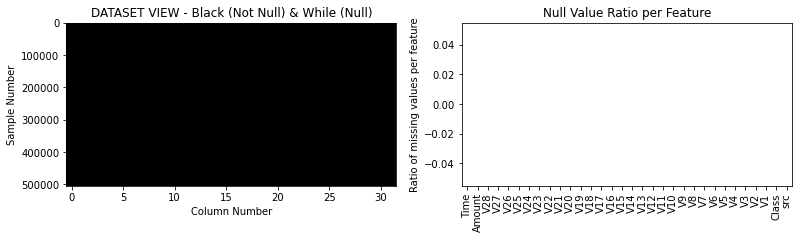

In [16]:
plt.subplots(1,2,figsize=(13,3))
plt.subplot(1,2,1)
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray") # we can test any condition in df using this graph
plt.xlabel("Column Number")
plt.ylabel("Sample Number")
plt.title("DATASET VIEW - Black (Not Null) & While (Null)")
plt.subplot(1,2,2)
df.isna().mean().sort_values().plot( kind="bar", title="Null Value Ratio per Feature", ylabel="Ratio of missing values per feature")
plt.show()

### <b><span style='color:#DEB078'>2.3 |</span><span style='color:#016CC9'> Unique Vallue Check</span></b> 

#### <b><span style='color:#DEB078'>2.3.1 |</span><span style='color:#016CC9'> Remove Duplicate Rows</span></b> 

In [17]:
df.shape

(503936, 32)

In [18]:
df=df.drop_duplicates(subset=df.columns.tolist()[:-1], keep='first').reset_index(drop=True)

In [19]:
df.shape

(502826, 32)

#### <b><span style='color:#DEB078'>2.3.2 |</span><span style='color:#016CC9'> Observe Unique in Columns</span></b> 

In [20]:
pd.DataFrame(df.nunique()).T

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,src
0,131997,493263,493267,493232,493239,493188,493117,493267,493211,493210,493266,493206,493263,493289,493252,493251,493284,493265,493252,493280,493277,493314,493283,493319,493219,493294,493314,493281,493294,38211,2,2


In [21]:
# Class should be categorical Variable
df[['Class']]=df[['Class']].astype('str')

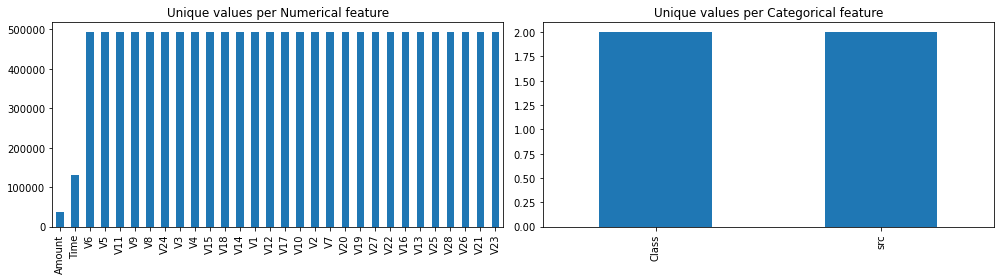

In [22]:
# Combined Plot

plt.subplots(1,2,figsize=(14,4),squeeze=False)
plt.subplot(1,2,1)
df.select_dtypes(include="number").nunique().sort_values().plot.bar(title="Unique values per Numerical feature");
plt.subplot(1,2,2)
df.select_dtypes(exclude="number").nunique().sort_values().plot.bar(title="Unique values per Categorical feature");
plt.tight_layout()
plt.show()

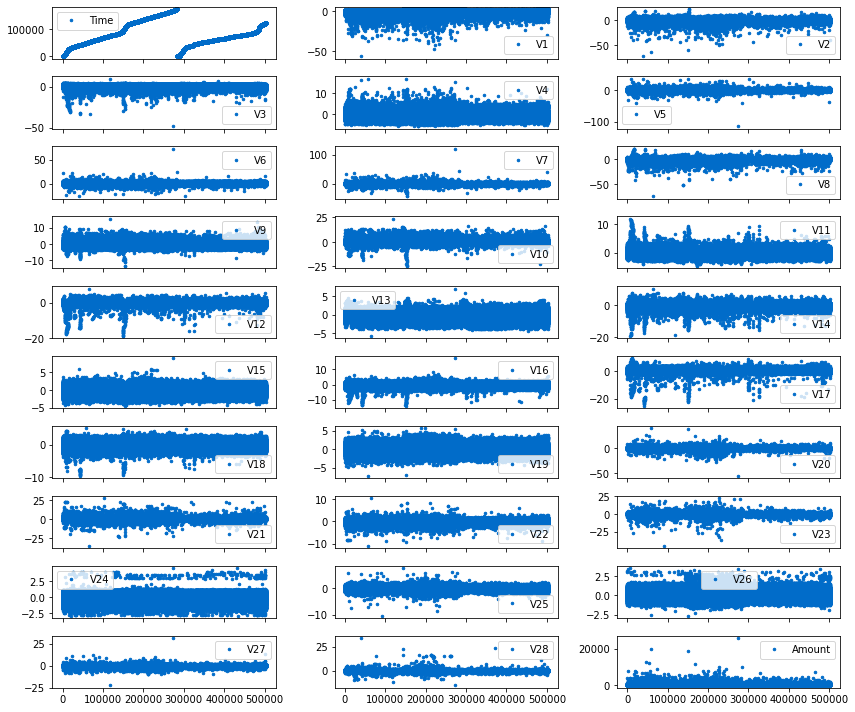

In [23]:
# For all Numerical columnn for all rows 
df.plot(lw=0, marker=".", subplots=True, layout=(-1, 3),
          figsize=(12,10), markersize=5,color='#016CC9')
plt.tight_layout()

## <b><div style='padding:15px;background-color:#79A7D3;color:white;border-radius:2px;font-size:90%'>3 | Univariate Analysis</div></b>  

### <b><span style='color:#DEB078'>3.2 |</span><span style='color:#016CC9'> Numerical Columns</span></b>

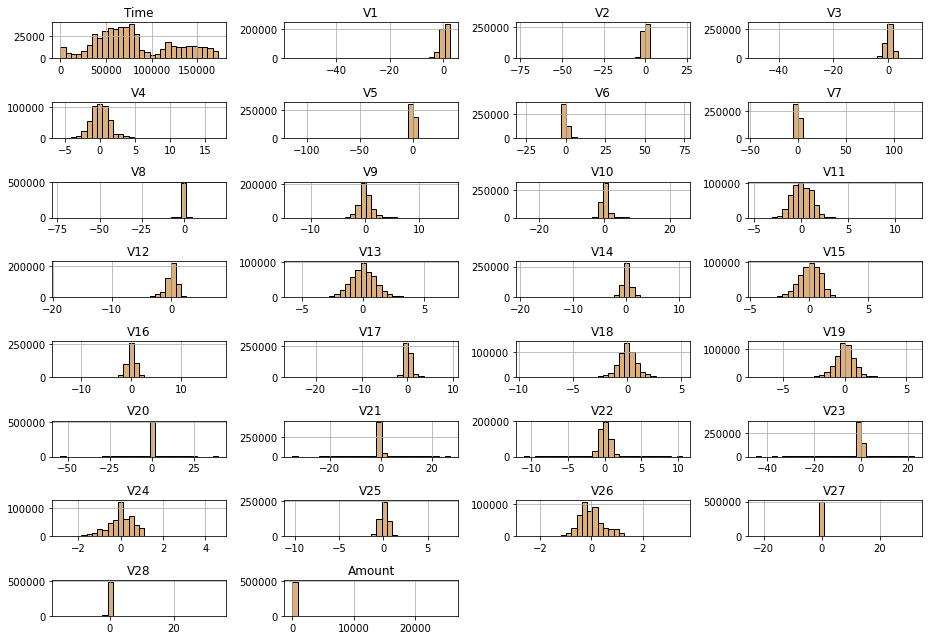

In [24]:
# Plots the histogram for each numerical feature in a separate subplot
figsize_val=(13,9)
layout_val=(-1, 4)
df.hist(bins=30, figsize=figsize_val, layout=layout_val, edgecolor="black",color='#DEB078')
plt.tight_layout();

In [25]:
df.skew()

Time       0.442659
V1        -3.043441
V2        -4.337787
V3        -2.019864
V4         0.505892
V5        -1.606346
V6         1.672344
V7         2.480013
V8        -8.690802
V9         0.503567
V10        1.308798
V11        0.220586
V12       -1.741945
V13        0.084768
V14       -1.610556
V15       -0.381709
V16       -0.847840
V17       -2.819096
V18       -0.198089
V19        0.038867
V20       -1.709731
V21        3.530710
V22       -0.168106
V23       -5.801069
V24       -0.477028
V25       -0.511933
V26        0.659465
V27       -1.029881
V28       12.987089
Amount    17.009079
Class     23.038893
dtype: float64

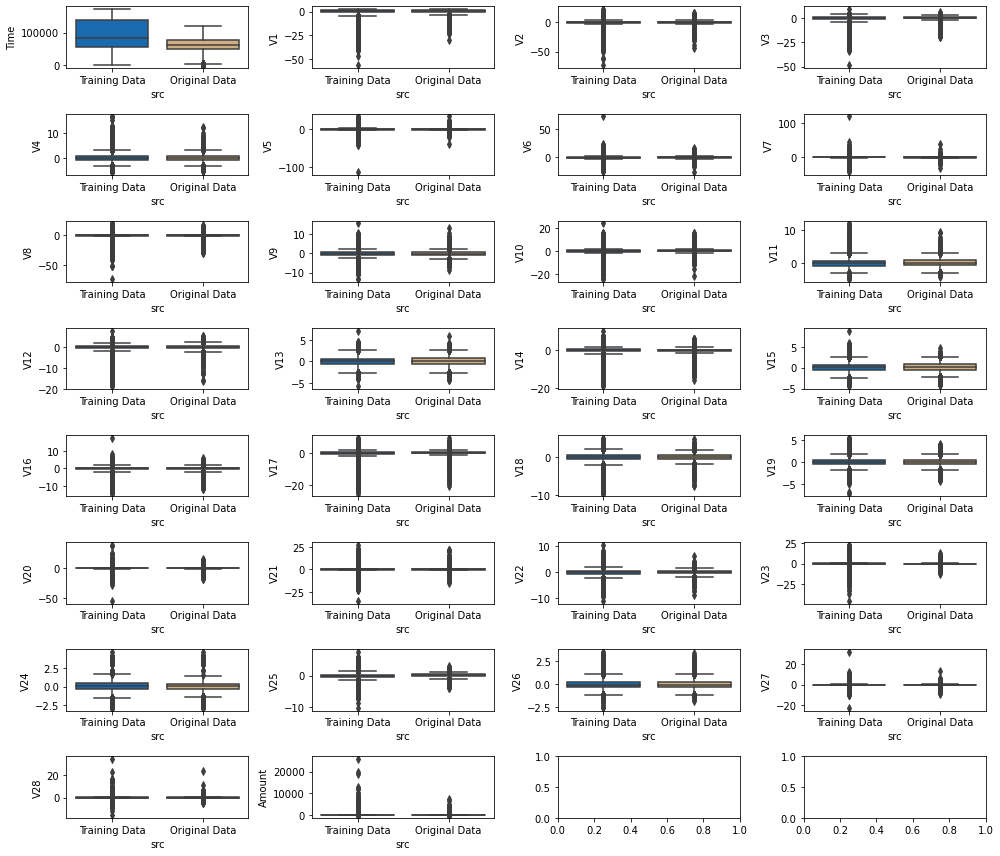

In [26]:
vars=df.columns.tolist()[:-1]
y=4

x=math.ceil(len(df.columns)/y)

plt.subplots(x,y,figsize=(14,12))

for i in range(1,len(vars)) :
    plt.subplot(x,y,i)
    sns.boxplot(data=df,y=vars[i-1],x='src',palette=['#016CC9','#DEB078'])
    #plt.xlabel(vars[i-1])
    #plt.title(vars[i-1])
plt.tight_layout()    
plt.show()

In [27]:
kk=(df.select_dtypes(include='number').columns).to_list()

df2=df[kk]


upper =df2.quantile(0.75)+1.5 *(df2.quantile(0.75)-df2.quantile(0.25))
lower = df2.quantile(0.25)-1.5 *(df2.quantile(0.75)-df2.quantile(0.25))

for i in kk:
    print('\nColumn -> ',i,'')   
    x= df2[ (df2[i]<round(lower[i],2)) |  (df2[i]>round(upper[i],2))][i].to_list()
    print('No of Outliers presesnt -> ',len(x))
    print('\n','*'*10)


Column ->  Time 
No of Outliers presesnt ->  0

 **********

Column ->  V1 
No of Outliers presesnt ->  9775

 **********

Column ->  V2 
No of Outliers presesnt ->  18138

 **********

Column ->  V3 
No of Outliers presesnt ->  8695

 **********

Column ->  V4 
No of Outliers presesnt ->  12601

 **********

Column ->  V5 
No of Outliers presesnt ->  19836

 **********

Column ->  V6 
No of Outliers presesnt ->  40007

 **********

Column ->  V7 
No of Outliers presesnt ->  11682

 **********

Column ->  V8 
No of Outliers presesnt ->  34682

 **********

Column ->  V9 
No of Outliers presesnt ->  12213

 **********

Column ->  V10 
No of Outliers presesnt ->  13567

 **********

Column ->  V11 
No of Outliers presesnt ->  852

 **********

Column ->  V12 
No of Outliers presesnt ->  28223

 **********

Column ->  V13 
No of Outliers presesnt ->  6458

 **********

Column ->  V14 
No of Outliers presesnt ->  26444

 **********

Column ->  V15 
No of Outliers presesnt ->  4147

 *****

### <b><span style='color:#DEB078'>3.2 |</span><span style='color:#016CC9'> Target Variable</span></b> 

In [28]:
df[['Class']].value_counts(normalize=True).round(decimals=3)*100

Class
0        99.8
1         0.2
dtype: float64

## <b><div style='padding:15px;background-color:#79A7D3;color:white;border-radius:2px;font-size:90%'>4 | Multivariate Analysis</div></b>    

### <b><span style='color:#DEB078'>4.1 |</span><span style='color:#016CC9'> Creating Relation Matrix and Graph</span></b>

In [29]:
temp_corr=df.corr()

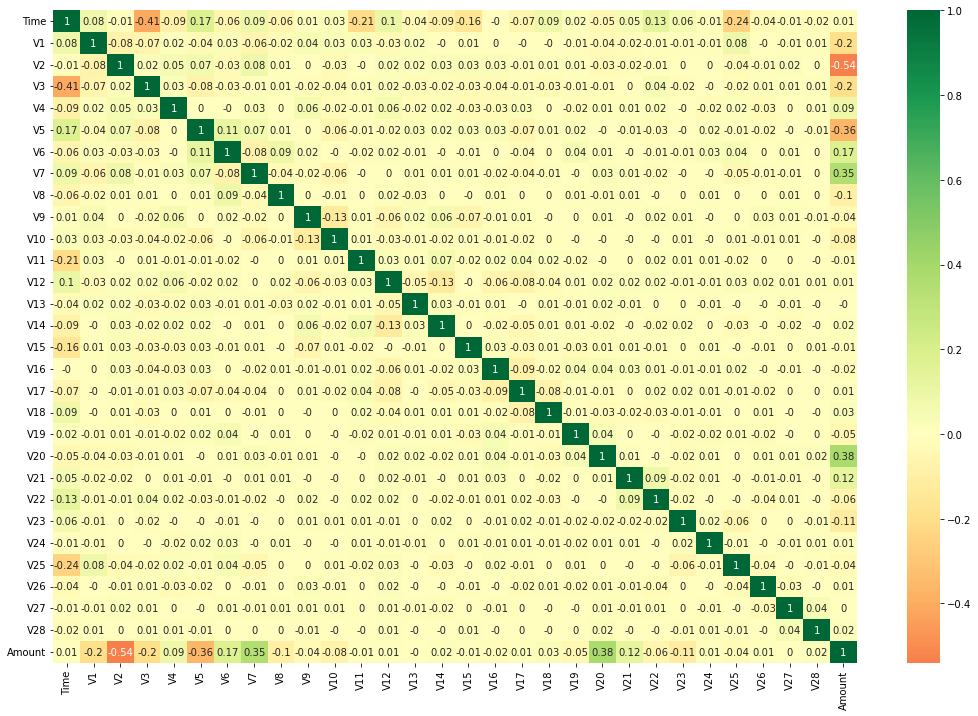

In [30]:
# Plot
plt.figure(figsize=(18,12))
sns.heatmap(df.corr().round(2), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### <b><span style='color:#DEB078'>4.2 |</span><span style='color:#016CC9'> Relation With Target Variable (Class)</span></b>

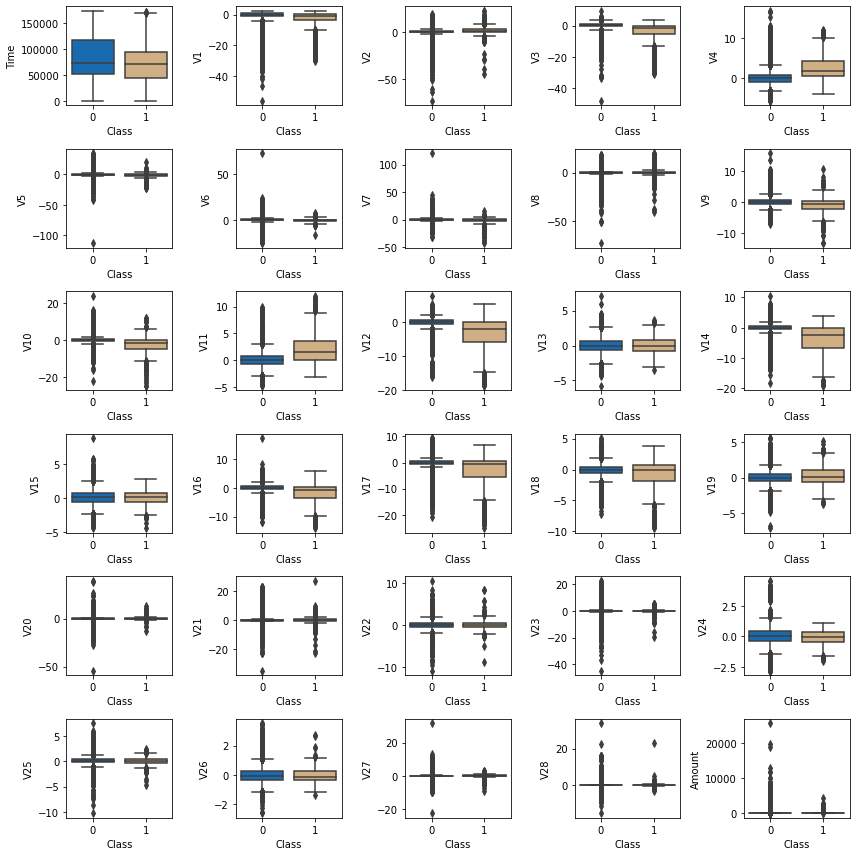

In [31]:
y=5
x=math.ceil((len(df.columns)-1)/y)-1

plt.subplots(x,y,figsize=(12,12))

for i in range(1,len(vars)) :
    plt.subplot(x,y,i)
    sns.boxplot(data=df,y=vars[i-1],x='Class',palette=['#016CC9','#DEB078'])
plt.tight_layout()    
plt.show()

<AxesSubplot:>

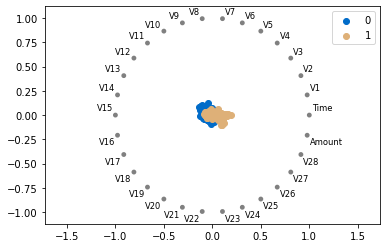

In [32]:
pd.plotting.radviz(df[vars], "Class",color=['#016CC9','#DEB078'])

### <b><span style='color:#DEB078'>4.3 |</span><span style='color:#016CC9'> Other Relationships (Leaving Class)</span></b> 

In [33]:
temp_corr=df.corr()
res = [(a, b) for idx, a in enumerate(temp_corr.index) for b in temp_corr.index[idx + 1:]]

strong=[]
moderate=[]
weak=[]
no_relationship=[]
for x,y in res:
    p=temp_corr[x][y]
    if p >= 0.75 or p <= -0.75:
        strong.append((x,y))
    elif p >= 0.50 or p <= -0.50:
        moderate.append((x,y))
    elif p >= 0.25 or p <= -0.25:
        weak.append((x,y))
    else :
        no_relationship.append((x,y))
    
print('\nStrong -> ',strong)
print('\nModerate -> ',moderate)
print('\nWeak -> ',weak)


Strong ->  []

Moderate ->  [('V2', 'Amount')]

Weak ->  [('Time', 'V3'), ('V5', 'Amount'), ('V7', 'Amount'), ('V20', 'Amount')]


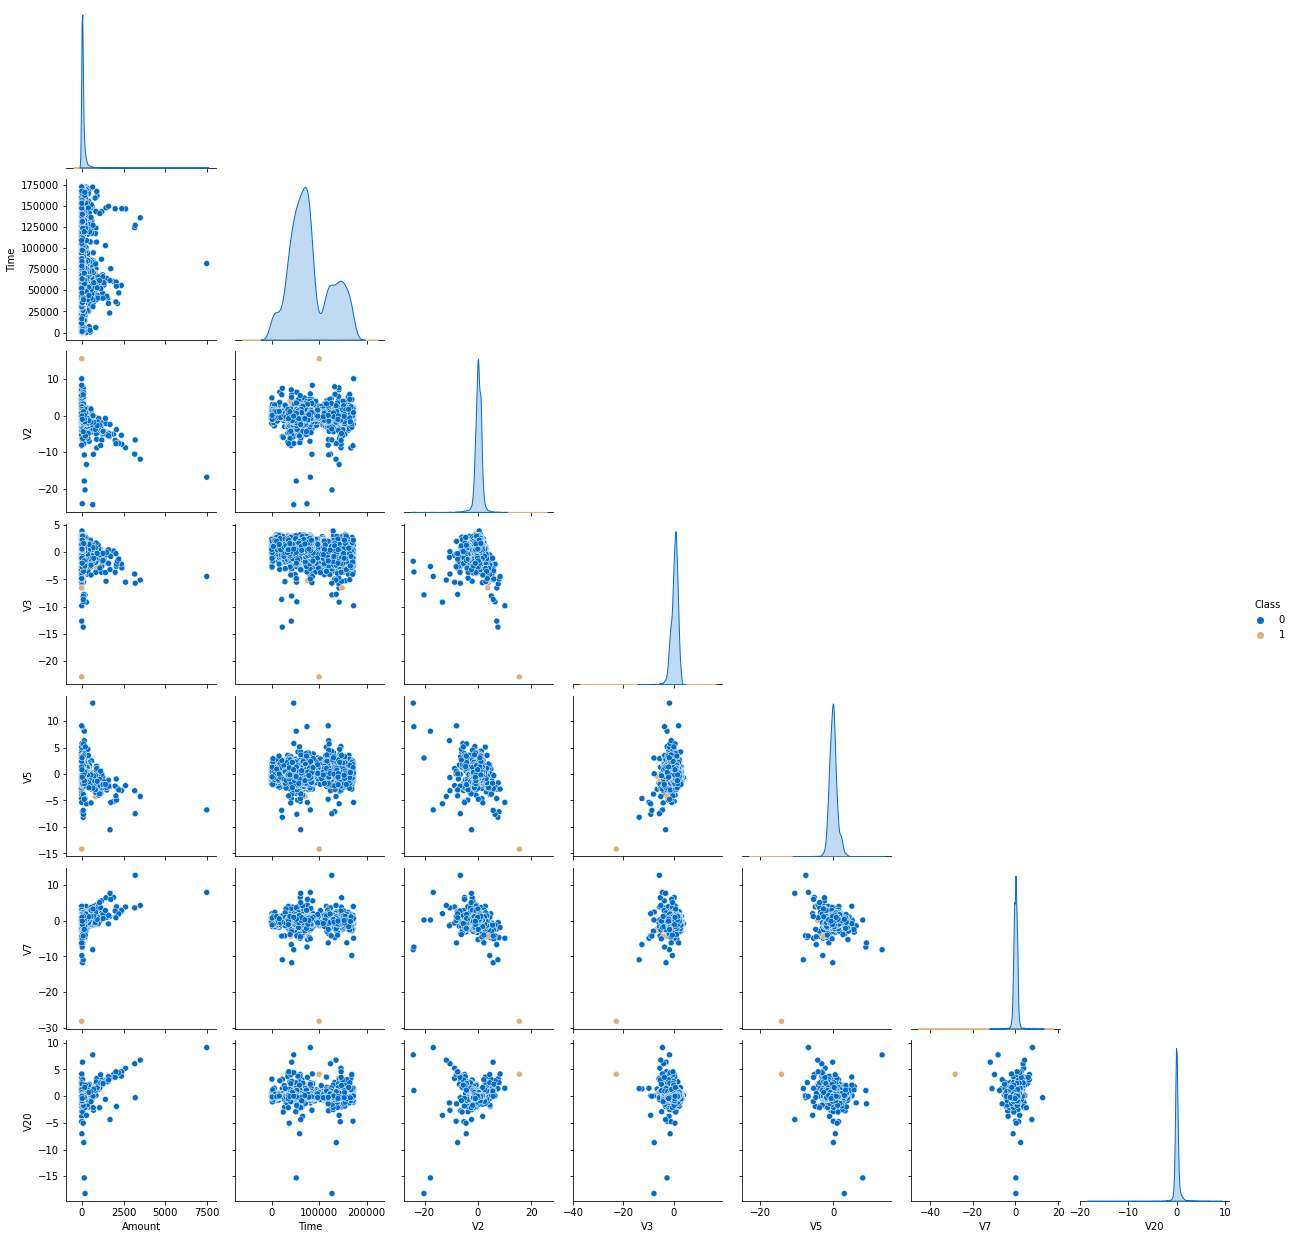

In [34]:
data=df.sample(frac=0.01,random_state=3) 
tt=['Amount','Time','V2','V3','V5','V7','V20','Class']

sns.pairplot(data=data[tt] ,
             hue='Class',
             palette=['#016CC9','#DEB078'],
             corner=True
)
                  
plt.show()

## <b><div style='padding:15px;background-color:#79A7D3;color:white;border-radius:2px;font-size:90%'>5 | Feature Engineering</div></b>      

### <b><span style='color:#DEB078'>5.1 |</span><span style='color:#016CC9'> Drop Src Column</span></b>  

In [35]:
df=df.drop(columns='src')
df_train=df_train.drop(columns='src')

### <b><span style='color:#DEB078'>5.2 |</span><span style='color:#016CC9'> Variable Splits</span></b>   

In [36]:
target_Variable     = 'Class'
input_features      = [col for col in df.columns if col not in ['kfold',target_Variable]]
# numerical_columns   = ['age', 'fnlwgt','capital.gain', 'capital.loss','hours.per.week']
# categorical_columns = [col for col in input_features if not col in numerical_columns]

### <b><span style='color:#DEB078'>5.3 |</span><span style='color:#016CC9'> Create Folds</span></b>   

In [37]:
def create_stratified_folds(data_df,no_of_splits,target_column):
    
    data_df['kfold']=-1
    
    #data_df=data_df.sample(frac=1,random_state=3) # random state to generate same set (seed)(for reproducibility.)
    
    kf=model_selection.StratifiedKFold(n_splits=no_of_splits,shuffle=True, random_state=10)
    
    for fold,(train_indexes,test_indexes) in enumerate(kf.split(data_df,data_df[target_column].values)):
        data_df.loc[test_indexes,'kfold']=np.int16(fold)
   
    return data_df

### <b><span style='color:#DEB078'>5.4 |</span><span style='color:#016CC9'> Handle Numerical Variables</span></b>

In [38]:
def handle_numerical_variables(train_data,test_data,numerical_columns):
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_data[[numerical_columns]])
    train_data[[numerical_columns]]=scaler.transform(train_data[[numerical_columns]]) 
    test_data[[numerical_columns]]=scaler.transform(test_data[[numerical_columns]])
    
    return train_data,test_data

## <b><div style='padding:15px;background-color:#79A7D3;color:white;border-radius:2px;font-size:90%'>6 | Model With Train Data</div></b>       

### <b><span style='color:#DEB078'>6.1 |</span><span style='color:#016CC9'> Logistic Regression With Train Data only </span></b> 

In [39]:
lr_2_prediction=0

df1=create_stratified_folds(df_train,5,'Class')

average_auc=[]

for i in range(5):
    train_df = df1[df1['kfold']!=i]
    test_df  = df1[df1['kfold']==i]

    train_df,test_df = handle_numerical_variables(train_df,test_df,'Amount')

    x_train_df = train_df.drop(columns=['Class','kfold'])
    y_train_df = train_df.Class

    x_test_df = test_df.drop(columns=['Class','kfold'])
    y_test_df = test_df.Class

    # initialize Logistic Regression model
    model = linear_model.LogisticRegression()
    model.fit(x_train_df, y_train_df)

    valid_preds = model.predict_proba(x_test_df)[:, 1]
    auc = metrics.roc_auc_score(y_test_df, valid_preds)
    
    print(f'FOLD -> {i} | AUC -> {auc}')
    average_auc.append(auc)
    print('*'*15)
    
    test_preds = model.predict_proba(test.drop(columns=['id']))[:, 1]
    lr_2_prediction =lr_2_prediction+ test_preds/5
    
print('Average AUC value -> ',np.array(average_auc).mean())

FOLD -> 0 | AUC -> 0.5361919116631086
***************
FOLD -> 1 | AUC -> 0.5816637507760032
***************
FOLD -> 2 | AUC -> 0.5808901802273422
***************
FOLD -> 3 | AUC -> 0.5449167171028177
***************
FOLD -> 4 | AUC -> 0.6953521399649282
***************
Average AUC value ->  0.5878029399468401


### <b><span style='color:#DEB078'>6.2 |</span><span style='color:#016CC9'> XGBClassifier With Train Data only </span></b> 

In [43]:
xgbparameters = {"objective":"binary:logistic","eval_metric": "auc","n_estimators": 1000,"random_state": 10,
    'tree_method': 'gpu_hist','predictor': 'gpu_predictor',
}


In [42]:

xg_2_prediction=0
df1=create_stratified_folds(df_train,5,'Class')
df1.Class=df1.Class.astype(np.int16)
average_auc=[]

for i in range(5):
    train_df = df1[df1['kfold']!=i]
    test_df  = df1[df1['kfold']==i]

    x_train_df = train_df.drop(columns=['Class','kfold'])
    y_train_df = train_df.Class

    x_test_df = test_df.drop(columns=['Class','kfold'])
    y_test_df = test_df.Class

    # initialize XGBClassifier model
    model = XGBClassifier(**xgbparameters)
    model.fit(x_train_df, y_train_df,verbose=0)
    
    valid_preds = model.predict_proba(x_test_df)[:, 1]
    auc = metrics.roc_auc_score(y_test_df,  valid_preds)
    average_auc.append(auc)
    
    print(f'FOLD -> {i} | AUC -> {auc}')
    print('*'*15)
    
    test_preds = model.predict_proba(test.drop(columns=['id']))[:, 1]
    xg_2_prediction =xg_2_prediction+ test_preds/5
    
print('Average AUC value -> ',np.array(average_auc).mean())

FOLD -> 0 | AUC -> 0.7694403387363262
***************
FOLD -> 1 | AUC -> 0.7345626455918155
***************
FOLD -> 2 | AUC -> 0.7165729948954074
***************
FOLD -> 3 | AUC -> 0.7834836849592586
***************
FOLD -> 4 | AUC -> 0.7791544834667461
***************
Average AUC value ->  0.7566428295299108


## <b><div style='padding:15px;background-color:#79A7D3;color:white;border-radius:2px;font-size:90%'>7 | Model With Original and Train Data</div></b>       

### <b><span style='color:#DEB078'>7.1 |</span><span style='color:#016CC9'> Logistic Regression Combined (Org and Train)</span></b> 

In [44]:
df1=create_stratified_folds(df,5,'Class')
lr_1_prediction=0
average_auc=[]

for i in range(5):
    train_df = df1[df1['kfold']!=i]
    test_df  = df1[df1['kfold']==i]

    train_df,test_df = handle_numerical_variables(train_df,test_df,'Amount')

    x_train_df = train_df.drop(columns=['Class','kfold'])
    y_train_df = train_df.Class

    x_test_df = test_df.drop(columns=['Class','kfold'])
    y_test_df = test_df.Class

    # initialize Logistic Regression model
    model = linear_model.LogisticRegression()
    model.fit(x_train_df, y_train_df)

    valid_preds = model.predict_proba(x_test_df)[:, 1]
    auc = metrics.roc_auc_score(y_test_df, valid_preds)
    
    print(f'FOLD -> {i} | AUC -> {auc}')
    average_auc.append(auc)
    print('*'*15)
    
    test_preds = model.predict_proba(test.drop(columns=['id']))[:, 1]
    lr_1_prediction =lr_1_prediction+ test_preds/5
    
print('Average AUC value -> ',np.array(average_auc).mean())

FOLD -> 0 | AUC -> 0.7776004568596496
***************
FOLD -> 1 | AUC -> 0.7540607547842506
***************
FOLD -> 2 | AUC -> 0.7641248874721024
***************
FOLD -> 3 | AUC -> 0.7634186669447672
***************
FOLD -> 4 | AUC -> 0.7357687476042462
***************
Average AUC value ->  0.7589947027330032


### <b><span style='color:#DEB078'>7.2 |</span><span style='color:#016CC9'> XGBClassifier Combined (Org and Train) </span></b> 

In [45]:

xg_1_prediction=0
df1=create_stratified_folds(df,5,'Class')
df1.Class=df1.Class.astype(np.int16)
average_auc=[]

for i in range(5):
    train_df = df1[df1['kfold']!=i]
    test_df  = df1[df1['kfold']==i]

    x_train_df = train_df.drop(columns=['Class','kfold'])
    y_train_df = train_df.Class

    x_test_df = test_df.drop(columns=['Class','kfold'])
    y_test_df = test_df.Class

    # initialize XGBClassifier model
    model = XGBClassifier(**xgbparameters)
    model.fit(x_train_df, y_train_df,verbose=0)
    
    valid_preds = model.predict_proba(x_test_df)[:, 1]
    auc = metrics.roc_auc_score(y_test_df,  valid_preds)
    average_auc.append(auc)
    
    print(f'FOLD -> {i} | AUC -> {auc}')
    print('*'*15)
    
    test_preds = model.predict_proba(test.drop(columns=['id']))[:, 1]
    xg_1_prediction =xg_1_prediction+ test_preds/5
    
print('Average AUC value -> ',np.array(average_auc).mean())

FOLD -> 0 | AUC -> 0.855605610235655
***************
FOLD -> 1 | AUC -> 0.8594695868914617
***************
FOLD -> 2 | AUC -> 0.8733241371518736
***************
FOLD -> 3 | AUC -> 0.8503734537813719
***************
FOLD -> 4 | AUC -> 0.8649518550989022
***************
Average AUC value ->  0.8607449286318529


In [ ]:
submission = pd.read_csv("/kaggle/input/playground-series-s3e4/sample_submission.csv")
submission['Class'] = xg_1_prediction
submission.to_csv("submit.csv",index=False)

### In Progress

## <b><div style='padding:15px;background-color:#79A7D3;color:white;border-radius:2px;font-size:90%'>8 | Other Notebooks</div></b>       

Please feel free to go through my other notebooks and provide your feedback
* https://www.kaggle.com/code/abhi011097/detailed-eda-basic-model-spaceship-titanic
* https://www.kaggle.com/code/abhi011097/learn-practice-pyspark-pandas-sql